In [3]:
import os
import random

import torch
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F

from AADB.AADB import AADB, AADB_binaries
from tqdm import tqdm
from utils.utils import *
from models.ResNet18 import RegressionNetwork
from loss_functions.rank_loss import RegRankLoss
import torch.nn as nn

### Variables


In [4]:
batch_size = 64
epochs = 200
load = False
ckpt = 'F:\Projects\Disertatie\ImageAestheticsGANs\classifier_ckpt\AADB_epoch_49_loss_0.7202_.pt'
lr=0.001
beta = 0.5  # Adam

In [5]:
image_dir = 'F:\Projects\Disertatie\ImageAestheticsGANs\AADB\ImageAesthetics_ECCV2016\datasetImages_warp256'
label_csv_path = 'F:\Projects\Disertatie\ImageAestheticsGANs\AADB\\'

## AADB

In [6]:
aadb = AADB_binaries(image_dir, label_csv_path)
aadb_test = AADB_binaries(image_dir, label_csv_path, test=True)
n_classes = AADB_binaries.get_classes()

[-0.2  0.2 -0.2 ...  0.   0.   0.4]
0.040364367046215675
[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 

tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1])


8958

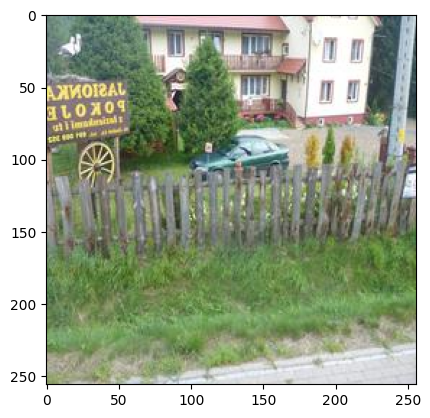

In [8]:
show_example(*aadb[0])
len(aadb)

tensor([0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0])


1000

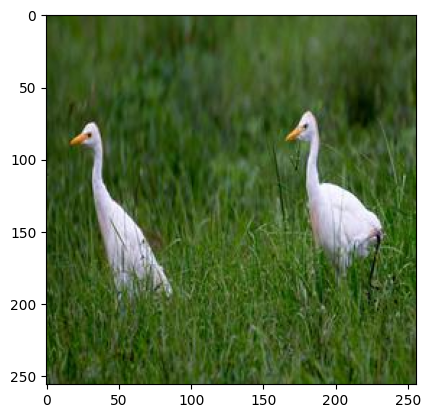

In [9]:
show_example(*aadb_test[0])
len(aadb_test)

## Dataloaders

In [10]:
val_size = 500
train_size = len(aadb) - val_size

train_ds, val_ds = random_split(aadb, [train_size, val_size])
len(train_ds), len(val_ds)

(8458, 500)

In [11]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=0, pin_memory=True, drop_last=True)
valid_dl = DataLoader(val_ds, batch_size, num_workers=0, pin_memory=True)

In [12]:
print(len(train_dl))
print(len(valid_dl))

132
8


In [13]:
for image, _ in train_dl:
    print(image.shape)
    break

torch.Size([64, 3, 256, 256])


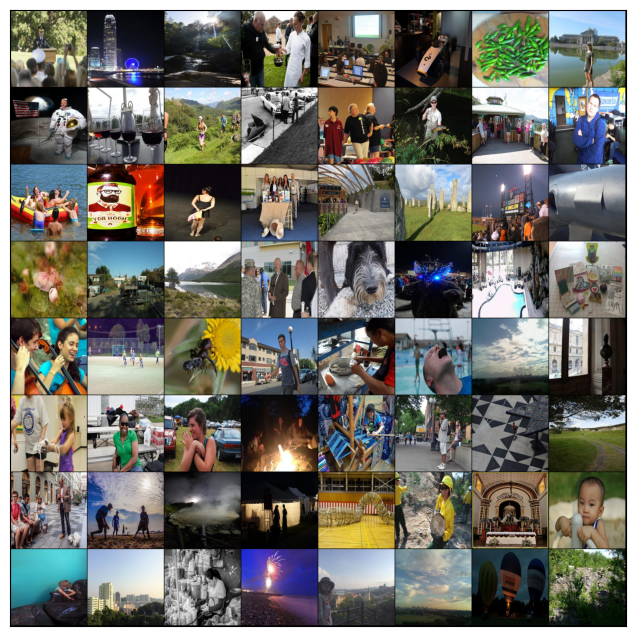

In [14]:
show_batch(train_dl)

## GPU

In [7]:
def get_default_device():
    '''Pick GPU if available'''
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    '''Move tensors to chosen device'''
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True).to(torch.float32)

In [8]:
class DeviceDataLoader():
    def __init__(self, dl ,device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [9]:
device = get_default_device()
device

device(type='cuda')

In [18]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

## Model and Criterion

In [19]:
# criterion = nn.CrossEntropyLoss()

In [20]:
criterion = nn.BCEWithLogitsLoss()

In [21]:
print(len(train_dl))
print(len(valid_dl))

132
8


In [10]:
model = RegressionNetwork(backbone='resnet18', num_attributes=11, pretrained=True)
model = model.to('cuda')

F:\Projects\Disertatie\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
F:\Projects\Disertatie\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Train

In [23]:
# opt = torch.optim.Adam(model.parameters(), lr=lr, betas=(beta, 0.999))
opt = torch.optim.SGD(params=model.parameters(), lr=lr, momentum=0.9)

if load:
    print("Loading checkpoint...")

    checkpoint = torch.load(ckpt)
    last_epoch = checkpoint['epoch']

    train_losses = checkpoint['train_losses']
    val_losses = checkpoint['val_losses']

    loss = train_losses[-1]

    model.load_state_dict(checkpoint['model'])
    opt.load_state_dict(checkpoint['optimizer'])
    model.eval()

else:
    last_epoch = 0

    train_losses = []
    val_losses = []

for epoch in range(last_epoch, epochs):

    # Training Phase
    model.train()

    pbar = tqdm(enumerate(train_dl), total=len(train_dl))
    for batch, (images, labels) in pbar:

        opt.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()

        # predicted = outputs.detach() > 0.5

        # correct = (predicted == labels.type(torch.uint8))

        # accuracy = correct.sum().item() / (len(correct) * n_classes)

        opt.step()

        # pbar.set_description("Epoch {}, Loss: {:.4f}, Accuracy: {:.4f}".format(
        #     epoch, float(loss), float(accuracy)))
        pbar.set_description("Epoch {}, Loss: {:.4f}".format(
            epoch, float(loss)))
    train_losses.append(loss)


    # Evaluation Phase
    model.eval()
    correct = 0
    total = 0
    pbar = tqdm(enumerate(valid_dl), total=len(valid_dl))
    for batch, (images, labels) in pbar:
        with torch.no_grad():
            outputs = model(images)

            predicted = outputs > 0.5

            correct += (predicted == labels.type(torch.uint8)).sum().item()
            total += len(labels) * n_classes

    accuracy = correct / total
    val_losses.append(accuracy)
    print('Accuracy of all test images: %.3f' % (accuracy * 100))
    filename = "{}_epoch_{}_loss_{:.4f}_.pt".format('AADB', epoch, accuracy)
    torch.save({'epoch': epoch,
                'model': model.state_dict(),
                'optimizer': opt.state_dict(),
                'train_losses': train_losses,
                'val_losses': val_losses
             },  os.path.join('F:\Projects\Disertatie\ImageAestheticsGANs\classifier_ckpt', filename))
    load = False

100%|██████████| 8/8 [00:00<00:00, 10.18it/s]


Accuracy of all test images: 67.000


100%|██████████| 8/8 [00:00<00:00, 10.30it/s]


Accuracy of all test images: 67.836


100%|██████████| 8/8 [00:00<00:00, 10.27it/s]


Accuracy of all test images: 67.927


100%|██████████| 8/8 [00:00<00:00, 10.38it/s]


Accuracy of all test images: 68.036


100%|██████████| 8/8 [00:00<00:00, 10.50it/s]


Accuracy of all test images: 68.127


100%|██████████| 8/8 [00:00<00:00, 10.28it/s]


Accuracy of all test images: 68.273


100%|██████████| 8/8 [00:00<00:00, 10.44it/s]


Accuracy of all test images: 68.418


100%|██████████| 8/8 [00:00<00:00, 10.56it/s]


Accuracy of all test images: 68.345


100%|██████████| 8/8 [00:00<00:00, 10.06it/s]


Accuracy of all test images: 68.509


100%|██████████| 8/8 [00:00<00:00, 10.55it/s]


Accuracy of all test images: 68.545


100%|██████████| 8/8 [00:00<00:00, 10.56it/s]


Accuracy of all test images: 68.691


100%|██████████| 8/8 [00:00<00:00, 10.49it/s]


Accuracy of all test images: 68.727


100%|██████████| 8/8 [00:00<00:00, 10.55it/s]


Accuracy of all test images: 68.782


100%|██████████| 8/8 [00:00<00:00, 10.47it/s]


Accuracy of all test images: 68.891


100%|██████████| 8/8 [00:00<00:00, 10.62it/s]


Accuracy of all test images: 69.000


100%|██████████| 8/8 [00:00<00:00, 10.52it/s]


Accuracy of all test images: 69.036


100%|██████████| 8/8 [00:00<00:00, 10.48it/s]


Accuracy of all test images: 69.255


100%|██████████| 8/8 [00:00<00:00, 10.43it/s]


Accuracy of all test images: 69.709


100%|██████████| 8/8 [00:00<00:00, 10.41it/s]


Accuracy of all test images: 69.909


100%|██████████| 8/8 [00:00<00:00, 10.72it/s]


Accuracy of all test images: 69.927


100%|██████████| 8/8 [00:00<00:00, 10.50it/s]


Accuracy of all test images: 70.036


100%|██████████| 8/8 [00:00<00:00, 10.34it/s]


Accuracy of all test images: 70.382


100%|██████████| 8/8 [00:00<00:00, 10.70it/s]


Accuracy of all test images: 70.364


100%|██████████| 8/8 [00:00<00:00, 10.48it/s]


Accuracy of all test images: 70.182


100%|██████████| 8/8 [00:00<00:00, 10.10it/s]


Accuracy of all test images: 70.527


100%|██████████| 8/8 [00:00<00:00, 10.61it/s]


Accuracy of all test images: 70.945


100%|██████████| 8/8 [00:00<00:00, 10.52it/s]


Accuracy of all test images: 70.782


100%|██████████| 8/8 [00:00<00:00, 10.13it/s]


Accuracy of all test images: 70.982


100%|██████████| 8/8 [00:00<00:00, 10.03it/s]


Accuracy of all test images: 70.964


100%|██████████| 8/8 [00:00<00:00, 10.11it/s]


Accuracy of all test images: 71.018


100%|██████████| 8/8 [00:00<00:00, 10.28it/s]


Accuracy of all test images: 71.491


100%|██████████| 8/8 [00:00<00:00, 10.17it/s]


Accuracy of all test images: 71.182


100%|██████████| 8/8 [00:00<00:00,  9.99it/s]


Accuracy of all test images: 71.218


100%|██████████| 8/8 [00:00<00:00,  9.93it/s]


Accuracy of all test images: 71.200


100%|██████████| 8/8 [00:00<00:00, 10.10it/s]


Accuracy of all test images: 71.345


100%|██████████| 8/8 [00:00<00:00, 10.02it/s]


Accuracy of all test images: 71.527


100%|██████████| 8/8 [00:00<00:00, 10.14it/s]


Accuracy of all test images: 71.455


100%|██████████| 8/8 [00:00<00:00, 10.17it/s]


Accuracy of all test images: 71.509


100%|██████████| 8/8 [00:00<00:00, 10.05it/s]


Accuracy of all test images: 71.782


100%|██████████| 8/8 [00:00<00:00, 10.15it/s]


Accuracy of all test images: 71.836


100%|██████████| 8/8 [00:00<00:00, 10.12it/s]


Accuracy of all test images: 71.582


100%|██████████| 8/8 [00:00<00:00, 10.15it/s]


Accuracy of all test images: 71.727


100%|██████████| 8/8 [00:00<00:00, 10.22it/s]


Accuracy of all test images: 71.873


100%|██████████| 8/8 [00:00<00:00, 10.13it/s]


Accuracy of all test images: 71.800


100%|██████████| 8/8 [00:00<00:00, 10.32it/s]


Accuracy of all test images: 71.982


100%|██████████| 8/8 [00:00<00:00, 10.12it/s]


Accuracy of all test images: 72.055


100%|██████████| 8/8 [00:00<00:00, 10.22it/s]


Accuracy of all test images: 71.909


100%|██████████| 8/8 [00:00<00:00, 10.31it/s]


Accuracy of all test images: 72.000


100%|██████████| 8/8 [00:00<00:00, 10.13it/s]


Accuracy of all test images: 72.109


100%|██████████| 8/8 [00:00<00:00, 10.15it/s]


Accuracy of all test images: 72.327


100%|██████████| 8/8 [00:00<00:00, 10.12it/s]


Accuracy of all test images: 72.236


100%|██████████| 8/8 [00:00<00:00, 10.09it/s]


Accuracy of all test images: 72.382


100%|██████████| 8/8 [00:00<00:00, 10.12it/s]


Accuracy of all test images: 72.491


100%|██████████| 8/8 [00:00<00:00, 10.29it/s]


Accuracy of all test images: 72.473


100%|██████████| 8/8 [00:00<00:00, 10.14it/s]


Accuracy of all test images: 72.236


100%|██████████| 8/8 [00:00<00:00, 10.10it/s]


Accuracy of all test images: 72.418


100%|██████████| 8/8 [00:00<00:00, 10.08it/s]


Accuracy of all test images: 72.491


100%|██████████| 8/8 [00:00<00:00, 10.11it/s]


Accuracy of all test images: 72.527


100%|██████████| 8/8 [00:00<00:00, 10.31it/s]


Accuracy of all test images: 72.764


100%|██████████| 8/8 [00:00<00:00, 10.14it/s]


Accuracy of all test images: 72.727


100%|██████████| 8/8 [00:00<00:00, 10.22it/s]


Accuracy of all test images: 72.891


100%|██████████| 8/8 [00:00<00:00, 10.12it/s]


Accuracy of all test images: 72.764


100%|██████████| 8/8 [00:00<00:00, 10.09it/s]


Accuracy of all test images: 72.745


100%|██████████| 8/8 [00:00<00:00,  9.72it/s]


Accuracy of all test images: 72.964


100%|██████████| 8/8 [00:00<00:00, 10.26it/s]


Accuracy of all test images: 72.964


100%|██████████| 8/8 [00:00<00:00,  9.96it/s]


Accuracy of all test images: 72.945


100%|██████████| 8/8 [00:00<00:00, 10.14it/s]


Accuracy of all test images: 73.218


100%|██████████| 8/8 [00:00<00:00, 10.03it/s]


Accuracy of all test images: 73.145


100%|██████████| 8/8 [00:00<00:00, 10.07it/s]


Accuracy of all test images: 73.145


100%|██████████| 8/8 [00:00<00:00, 10.15it/s]


Accuracy of all test images: 73.218


100%|██████████| 8/8 [00:00<00:00, 10.10it/s]


Accuracy of all test images: 73.000


100%|██████████| 8/8 [00:00<00:00, 10.29it/s]


Accuracy of all test images: 73.382


100%|██████████| 8/8 [00:00<00:00, 10.14it/s]


Accuracy of all test images: 73.236


100%|██████████| 8/8 [00:00<00:00, 10.15it/s]


Accuracy of all test images: 73.127


100%|██████████| 8/8 [00:00<00:00, 10.21it/s]


Accuracy of all test images: 73.182


100%|██████████| 8/8 [00:00<00:00, 10.01it/s]


Accuracy of all test images: 73.236


100%|██████████| 8/8 [00:00<00:00, 10.16it/s]


Accuracy of all test images: 73.364


100%|██████████| 8/8 [00:00<00:00, 10.12it/s]


Accuracy of all test images: 73.382


100%|██████████| 8/8 [00:00<00:00, 10.39it/s]


Accuracy of all test images: 73.255


100%|██████████| 8/8 [00:00<00:00, 10.31it/s]


Accuracy of all test images: 73.236


100%|██████████| 8/8 [00:00<00:00, 10.23it/s]


Accuracy of all test images: 73.455


100%|██████████| 8/8 [00:00<00:00, 10.32it/s]


Accuracy of all test images: 73.291


100%|██████████| 8/8 [00:00<00:00, 10.24it/s]


Accuracy of all test images: 73.418


100%|██████████| 8/8 [00:00<00:00, 10.23it/s]


Accuracy of all test images: 73.382


100%|██████████| 8/8 [00:00<00:00, 10.38it/s]


Accuracy of all test images: 73.709


100%|██████████| 8/8 [00:00<00:00, 10.16it/s]


Accuracy of all test images: 73.400


100%|██████████| 8/8 [00:00<00:00, 10.16it/s]


Accuracy of all test images: 73.455


100%|██████████| 8/8 [00:00<00:00, 10.16it/s]


Accuracy of all test images: 73.473


100%|██████████| 8/8 [00:00<00:00, 10.00it/s]


Accuracy of all test images: 73.600


100%|██████████| 8/8 [00:00<00:00, 10.15it/s]


Accuracy of all test images: 73.545


100%|██████████| 8/8 [00:00<00:00, 10.17it/s]


Accuracy of all test images: 73.709


100%|██████████| 8/8 [00:00<00:00, 10.04it/s]


Accuracy of all test images: 73.873


100%|██████████| 8/8 [00:00<00:00, 10.19it/s]


Accuracy of all test images: 73.600


100%|██████████| 8/8 [00:00<00:00, 10.23it/s]


Accuracy of all test images: 73.764


100%|██████████| 8/8 [00:00<00:00, 10.27it/s]


Accuracy of all test images: 73.782


100%|██████████| 8/8 [00:00<00:00, 10.16it/s]


Accuracy of all test images: 73.655


100%|██████████| 8/8 [00:00<00:00, 10.24it/s]


Accuracy of all test images: 74.055


100%|██████████| 8/8 [00:00<00:00,  9.95it/s]


Accuracy of all test images: 73.836


100%|██████████| 8/8 [00:00<00:00, 10.20it/s]


Accuracy of all test images: 74.055


100%|██████████| 8/8 [00:00<00:00, 10.28it/s]


Accuracy of all test images: 73.982


100%|██████████| 8/8 [00:00<00:00, 10.30it/s]


Accuracy of all test images: 74.036


100%|██████████| 8/8 [00:00<00:00, 10.13it/s]


Accuracy of all test images: 74.018


100%|██████████| 8/8 [00:00<00:00, 10.25it/s]


Accuracy of all test images: 73.855


100%|██████████| 8/8 [00:00<00:00, 10.15it/s]


Accuracy of all test images: 73.782


100%|██████████| 8/8 [00:00<00:00, 10.20it/s]


Accuracy of all test images: 73.855


100%|██████████| 8/8 [00:00<00:00, 10.08it/s]


Accuracy of all test images: 73.691


100%|██████████| 8/8 [00:00<00:00, 10.06it/s]


Accuracy of all test images: 74.273


100%|██████████| 8/8 [00:00<00:00,  9.97it/s]


Accuracy of all test images: 74.200


100%|██████████| 8/8 [00:00<00:00, 10.05it/s]


Accuracy of all test images: 73.873


100%|██████████| 8/8 [00:00<00:00,  9.62it/s]


Accuracy of all test images: 73.927


100%|██████████| 8/8 [00:00<00:00,  9.70it/s]


Accuracy of all test images: 73.891


100%|██████████| 8/8 [00:00<00:00,  9.59it/s]


Accuracy of all test images: 74.073


100%|██████████| 8/8 [00:00<00:00, 10.13it/s]


Accuracy of all test images: 74.255


100%|██████████| 8/8 [00:00<00:00,  9.82it/s]


Accuracy of all test images: 74.145


100%|██████████| 8/8 [00:00<00:00,  9.53it/s]


Accuracy of all test images: 74.309


100%|██████████| 8/8 [00:00<00:00, 10.07it/s]


Accuracy of all test images: 74.182


100%|██████████| 8/8 [00:00<00:00,  9.82it/s]


Accuracy of all test images: 74.073


100%|██████████| 8/8 [00:00<00:00,  9.67it/s]


Accuracy of all test images: 74.109


100%|██████████| 8/8 [00:00<00:00,  9.91it/s]


Accuracy of all test images: 74.000


100%|██████████| 8/8 [00:00<00:00,  9.67it/s]


Accuracy of all test images: 74.218


100%|██████████| 8/8 [00:00<00:00, 10.07it/s]


Accuracy of all test images: 74.309


100%|██████████| 8/8 [00:00<00:00,  9.64it/s]


Accuracy of all test images: 74.091


100%|██████████| 8/8 [00:00<00:00,  9.63it/s]


Accuracy of all test images: 74.055


100%|██████████| 8/8 [00:00<00:00,  9.99it/s]


Accuracy of all test images: 74.327


100%|██████████| 8/8 [00:00<00:00,  9.91it/s]


Accuracy of all test images: 74.400


100%|██████████| 8/8 [00:00<00:00,  9.78it/s]


Accuracy of all test images: 74.455


100%|██████████| 8/8 [00:00<00:00,  9.98it/s]


Accuracy of all test images: 74.164


100%|██████████| 8/8 [00:00<00:00, 10.02it/s]


Accuracy of all test images: 74.145


100%|██████████| 8/8 [00:00<00:00,  9.89it/s]


Accuracy of all test images: 74.564


100%|██████████| 8/8 [00:00<00:00, 10.26it/s]


Accuracy of all test images: 74.636


100%|██████████| 8/8 [00:00<00:00, 10.00it/s]


Accuracy of all test images: 74.400


100%|██████████| 8/8 [00:00<00:00, 10.02it/s]


Accuracy of all test images: 74.564


100%|██████████| 8/8 [00:00<00:00,  9.89it/s]


Accuracy of all test images: 74.327


100%|██████████| 8/8 [00:00<00:00, 10.04it/s]


Accuracy of all test images: 74.218


100%|██████████| 8/8 [00:00<00:00, 10.28it/s]


Accuracy of all test images: 74.236


100%|██████████| 8/8 [00:00<00:00, 10.08it/s]


Accuracy of all test images: 74.745


100%|██████████| 8/8 [00:00<00:00,  9.97it/s]


Accuracy of all test images: 74.582


100%|██████████| 8/8 [00:00<00:00,  9.78it/s]


Accuracy of all test images: 74.600


100%|██████████| 8/8 [00:00<00:00, 10.36it/s]


Accuracy of all test images: 74.400


100%|██████████| 8/8 [00:00<00:00, 10.24it/s]


Accuracy of all test images: 74.364


100%|██████████| 8/8 [00:00<00:00, 10.06it/s]


Accuracy of all test images: 74.527


100%|██████████| 8/8 [00:00<00:00,  9.99it/s]


Accuracy of all test images: 74.473


100%|██████████| 8/8 [00:00<00:00, 10.10it/s]


Accuracy of all test images: 74.327


100%|██████████| 8/8 [00:00<00:00, 10.09it/s]


Accuracy of all test images: 74.345


100%|██████████| 8/8 [00:00<00:00, 10.15it/s]


Accuracy of all test images: 74.618


100%|██████████| 8/8 [00:00<00:00, 10.11it/s]


Accuracy of all test images: 74.545


100%|██████████| 8/8 [00:00<00:00, 10.19it/s]


Accuracy of all test images: 74.545


100%|██████████| 8/8 [00:00<00:00, 10.11it/s]


Accuracy of all test images: 74.636


100%|██████████| 8/8 [00:00<00:00, 10.17it/s]


Accuracy of all test images: 74.673


100%|██████████| 8/8 [00:00<00:00,  9.91it/s]


Accuracy of all test images: 74.327


100%|██████████| 8/8 [00:00<00:00, 10.15it/s]


Accuracy of all test images: 74.618


100%|██████████| 8/8 [00:00<00:00, 10.01it/s]


Accuracy of all test images: 74.564


100%|██████████| 8/8 [00:00<00:00, 10.37it/s]


Accuracy of all test images: 74.582


100%|██████████| 8/8 [00:00<00:00, 10.02it/s]


Accuracy of all test images: 74.582


100%|██████████| 8/8 [00:00<00:00, 10.11it/s]


Accuracy of all test images: 74.582


100%|██████████| 8/8 [00:00<00:00,  9.86it/s]


Accuracy of all test images: 74.418


100%|██████████| 8/8 [00:00<00:00, 10.17it/s]


Accuracy of all test images: 74.545


100%|██████████| 8/8 [00:00<00:00,  9.58it/s]


Accuracy of all test images: 74.527


100%|██████████| 8/8 [00:00<00:00, 10.11it/s]


Accuracy of all test images: 74.836


100%|██████████| 8/8 [00:00<00:00, 10.03it/s]


Accuracy of all test images: 74.582


100%|██████████| 8/8 [00:00<00:00,  9.80it/s]


Accuracy of all test images: 74.655


100%|██████████| 8/8 [00:00<00:00, 10.40it/s]


Accuracy of all test images: 74.836


100%|██████████| 8/8 [00:00<00:00, 10.10it/s]


Accuracy of all test images: 74.364


100%|██████████| 8/8 [00:00<00:00, 10.16it/s]


Accuracy of all test images: 74.582


100%|██████████| 8/8 [00:00<00:00, 10.21it/s]


Accuracy of all test images: 74.800


100%|██████████| 8/8 [00:00<00:00, 10.00it/s]


Accuracy of all test images: 74.455


100%|██████████| 8/8 [00:00<00:00, 10.10it/s]


Accuracy of all test images: 74.709


100%|██████████| 8/8 [00:00<00:00,  9.92it/s]


Accuracy of all test images: 74.491


100%|██████████| 8/8 [00:00<00:00,  9.88it/s]


Accuracy of all test images: 74.182


100%|██████████| 8/8 [00:00<00:00, 10.04it/s]


Accuracy of all test images: 74.473


100%|██████████| 8/8 [00:00<00:00, 10.02it/s]


Accuracy of all test images: 74.545


100%|██████████| 8/8 [00:00<00:00,  9.89it/s]


Accuracy of all test images: 74.455


100%|██████████| 8/8 [00:00<00:00, 10.00it/s]


Accuracy of all test images: 74.636


100%|██████████| 8/8 [00:00<00:00, 10.04it/s]


Accuracy of all test images: 74.582


100%|██████████| 8/8 [00:00<00:00,  9.73it/s]


Accuracy of all test images: 74.545


100%|██████████| 8/8 [00:00<00:00, 10.14it/s]


Accuracy of all test images: 74.636


100%|██████████| 8/8 [00:00<00:00,  9.85it/s]


Accuracy of all test images: 74.400


100%|██████████| 8/8 [00:00<00:00,  9.66it/s]


Accuracy of all test images: 74.800


100%|██████████| 8/8 [00:00<00:00, 10.10it/s]


Accuracy of all test images: 74.745


100%|██████████| 8/8 [00:00<00:00,  9.96it/s]


Accuracy of all test images: 74.364


100%|██████████| 8/8 [00:00<00:00, 10.31it/s]


Accuracy of all test images: 74.964


100%|██████████| 8/8 [00:00<00:00, 10.09it/s]


Accuracy of all test images: 74.836


100%|██████████| 8/8 [00:00<00:00,  9.80it/s]


Accuracy of all test images: 74.564


100%|██████████| 8/8 [00:00<00:00, 10.14it/s]


Accuracy of all test images: 74.655


100%|██████████| 8/8 [00:00<00:00, 10.13it/s]


Accuracy of all test images: 74.927


100%|██████████| 8/8 [00:00<00:00,  9.75it/s]


Accuracy of all test images: 74.436


100%|██████████| 8/8 [00:00<00:00,  9.68it/s]


Accuracy of all test images: 74.618


100%|██████████| 8/8 [00:00<00:00, 10.19it/s]


Accuracy of all test images: 74.836


100%|██████████| 8/8 [00:00<00:00, 10.18it/s]


Accuracy of all test images: 74.764


100%|██████████| 8/8 [00:00<00:00,  9.98it/s]


Accuracy of all test images: 74.618


100%|██████████| 8/8 [00:00<00:00,  9.88it/s]


Accuracy of all test images: 74.600


100%|██████████| 8/8 [00:00<00:00, 10.10it/s]


Accuracy of all test images: 74.436


100%|██████████| 8/8 [00:00<00:00, 10.15it/s]


Accuracy of all test images: 74.873


100%|██████████| 8/8 [00:00<00:00, 10.10it/s]


Accuracy of all test images: 74.782


100%|██████████| 8/8 [00:00<00:00,  9.94it/s]


Accuracy of all test images: 74.400


100%|██████████| 8/8 [00:00<00:00,  9.92it/s]


Accuracy of all test images: 74.582


100%|██████████| 8/8 [00:00<00:00, 10.10it/s]


Accuracy of all test images: 74.600


100%|██████████| 8/8 [00:00<00:00, 10.09it/s]


Accuracy of all test images: 74.455


100%|██████████| 8/8 [00:00<00:00,  9.82it/s]


Accuracy of all test images: 74.491


100%|██████████| 8/8 [00:00<00:00, 10.26it/s]

Accuracy of all test images: 74.564


## Evaluate

In [11]:
ckpt = 'F:\Projects\Disertatie\ImageAestheticsGANs\classifier_ckpt\AADB_epoch_199_loss_0.7456_.pt'

In [12]:
model = RegressionNetwork(backbone='resnet18', num_attributes=11, pretrained=True)
model = model.to('cuda')
model.load_state_dict(torch.load(ckpt)['model'])
model.eval()

RegressionNetwork(
  (model): Sequential(
    (0): Backbone(
      (model): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (4): Sequential(
          (0): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU(inplace=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (1): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [13]:
test_dl = DataLoader(aadb_test, batch_size, shuffle=False, num_workers=0, pin_memory=True, drop_last=False)
test_dl = DeviceDataLoader(test_dl, device)

In [14]:
correct = 0
total = 0
with torch.no_grad():
    for batch, (images, labels) in tqdm(enumerate(test_dl), total=len(test_dl)):

        outputs = model(images)

        predicted = outputs > 0.5

        correct += (predicted == labels.type(torch.uint8)).sum().item()
        total += len(labels) * n_classes

    accuracy = correct / total
    print('Accuracy of all test images: %.3f' % (accuracy * 100))

100%|██████████| 16/16 [00:11<00:00,  1.42it/s]

Accuracy of all test images: 74.518


In [27]:
def plot_loss(train_losses):
    train_losses_list = [i.item() for i in train_losses]
    # val_losses_list = [i for i in val_losses]
    plt.plot(train_losses_list, '-bx')
    # plt.plot(val_losses_list, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training'])
    plt.title('Loss vs No. of epochs')

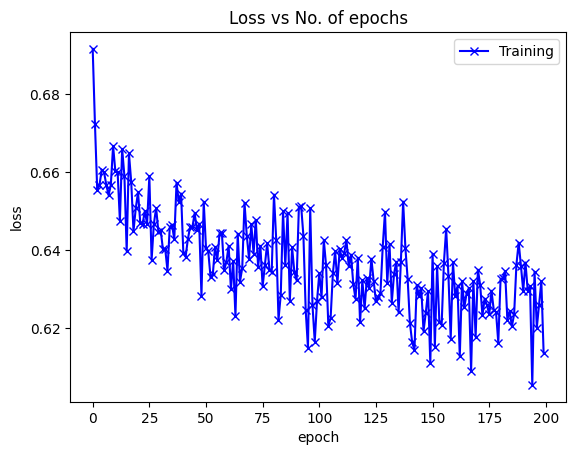

In [28]:
checkpoint = torch.load(ckpt)
train_losses = torch.load(ckpt)['train_losses']
# val_losses = torch.load(ckpt)['val_losses']
plot_loss(train_losses)

## Application

In [43]:
i = random.randint(0, len(aadb_test))
x, y = aadb[i]
x_tensor = x.to("cuda").unsqueeze(0)
y_pred = model(x_tensor)    #.cpu().detach().numpy()
print(y_pred)
predicted = y_pred > 0.5
# print(predicted)
predicted = predicted.cpu().detach().numpy()
print(predicted)
y = y.numpy()
print(y)

tensor([6.6693e-04, 2.2200e-03, 1.5483e-01, 1.3229e-02, 3.9786e-03, 9.9946e-01,
        8.4109e-01, 3.2673e-04, 5.2215e-01, 4.5987e-04, 1.7983e-01],
       device='cuda:0', grad_fn=<SigmoidBackward0>)
[False False False False False  True  True False  True False False]
[0 0 0 1 0 1 1 0 1 0 0]


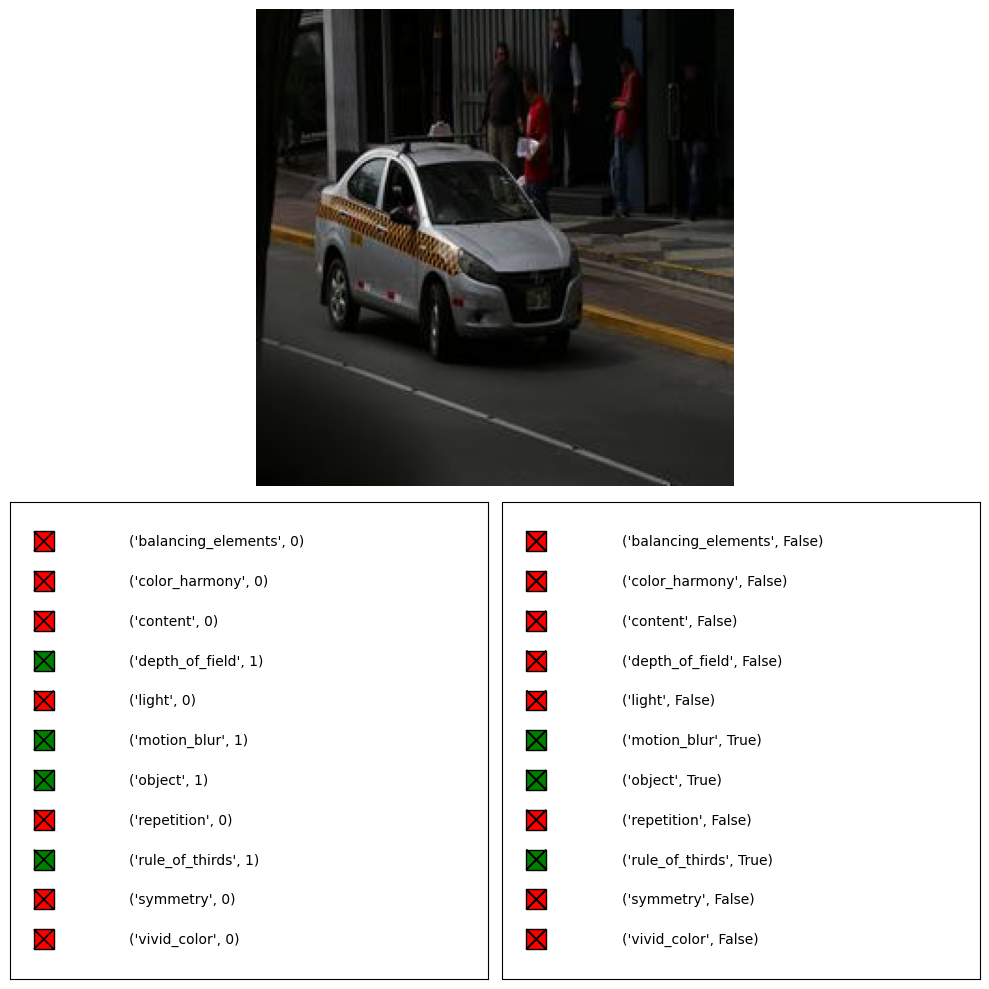

In [44]:
display_aesthetics(x, y, predicted, interval=[0, 0], score=False)